This example shows the simplicity and strengths of HDC on a simple [toy dataset](https://www.kaggle.com/datasets/uciml/zoo-animal-classification). The data contains 101 different animals with each 17 features such as if they are airborne, their amount of legs etc. We will demonstrate the power of HDC by making a simple classifier for this dataset.

Let us first define the aforementioned operations that we can do with HDVs.

In [1]:
using Random

"""
Construct a binary vector. By default 10000 elements long.
"""
bitHDV(N::Int=10000) = bitrand(N)


"""
Bundles binary hyperdimensional vectors based on the element-wise majority rule.
"""
function bitadd(vectors::BitVector ...)
    v = reduce(.+, vectors)
    n = length(vectors) / 2
    x = [i > n ? 1 : i < n ? 0 : rand(0:1) for i in v]
    return convert(BitVector, x)
end


"""
Binds binary hyperdimensional vectors based on an element-wise XOR gate.
"""
bitbind(vectors::BitVector ...) =  reduce(.⊻, vectors)


"""
Permutes a binary hyperdimensional vector by an adjustable circular shift.
"""
bitperm(vector::BitVector, k::Int=1) = circshift(vector, k)


"""
Calculates the Hamming distance between two binary vectors.
"""
hamming(x::BitVector, y::BitVector) = sum(x .!= y)/length(x)

hamming

Here we see the dataset.

In [2]:
using DataFrames, CSV
data = CSV.read("zoodata/zoo.csv", DataFrame)

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed
,String15,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,aardvark,1,0,0,1,0,0,1,1
2,antelope,1,0,0,1,0,0,0,1
3,bass,0,0,1,0,0,1,1,1
4,bear,1,0,0,1,0,0,1,1
5,boar,1,0,0,1,0,0,1,1
6,buffalo,1,0,0,1,0,0,0,1
7,calf,1,0,0,1,0,0,0,1
8,carp,0,0,1,0,0,1,0,1
9,catfish,0,0,1,0,0,1,1,1


Let us extract the class type of every animal. The class of an animal can be mammal, bird, reptile, fish, amphibian, bug or invertebrate.

In [3]:
classls = data.class_type

101-element Vector{Int64}:
 1
 1
 4
 1
 1
 1
 1
 4
 4
 1
 1
 2
 4
 ⋮
 5
 3
 3
 4
 1
 1
 2
 1
 6
 1
 7
 2

Here we collect the index of every animal in the dataset and store them seperated by class type to easily retreive them later.

In [4]:
mammal_idx = [i for i in 1:101 if data.class_type[i] == 1]
bird_idx = [i for i in 1:101 if data.class_type[i] == 2]
reptile_idx = [i for i in 1:101 if data.class_type[i] == 3]
fish_idx = [i for i in 1:101 if data.class_type[i] == 4]
amphibian_idx = [i for i in 1:101 if data.class_type[i] == 5]
bug_idx = [i for i in 1:101 if data.class_type[i] == 6]
invertebrate_idx = [i for i in 1:101 if data.class_type[i] == 7]

indices = [mammal_idx, bird_idx, reptile_idx, fish_idx, amphibian_idx, bug_idx, invertebrate_idx]

7-element Vector{Vector{Int64}}:
 [1, 2, 4, 5, 6, 7, 10, 11, 18, 20  …  69, 70, 71, 75, 76, 85, 94, 95, 97, 99]
 [12, 17, 21, 22, 24, 34, 38, 42, 44, 57, 58, 59, 60, 72, 79, 80, 84, 88, 96, 101]
 [63, 77, 81, 91, 92]
 [3, 8, 9, 13, 19, 35, 39, 61, 62, 74, 83, 87, 93]
 [26, 27, 53, 90]
 [25, 31, 40, 41, 43, 52, 89, 98]
 [14, 15, 16, 47, 54, 73, 78, 82, 86, 100]

Because every feature is binary except for the amount of legs, we will rearrange the dataset to be easily manipulated later on.

In [5]:
legs0 = [i == 0 ? 1 : 0 for i in data.legs]
legs2 = [i == 2 ? 1 : 0 for i in data.legs]
legs4 = [i == 4 ? 1 : 0 for i in data.legs]
legs5 = [i == 5 ? 1 : 0 for i in data.legs]
legs6 = [i == 6 ? 1 : 0 for i in data.legs]
legs8 = [i == 8 ? 1 : 0 for i in data.legs]

select!(data, Not(:class_type))
select!(data, Not(:legs))

data[!, :legs0] = legs0
data[!, :legs2] = legs2
data[!, :legs4] = legs4
data[!, :legs5] = legs5
data[!, :legs6] = legs6
data[!, :legs8] = legs8

101-element Vector{Int64}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

Representing a range of numbers by hyperdimensional vectors is also simple. We construct a random hyperdimensional vector representing the lower bound of the interval. Next, we replace a fraction of the vector by random bits which must represent the number in the next step. This assures us in this case that having 2 legs is more similar to having 4 legs than 8 legs.

We also create random hyperdimensional vectors for every other feature and throw them together in a list.

In [6]:
"""
Creates a list of binary hyperdimensional vectors representing an interval of numbers by constructing a random HDV representing the lower bound of the interval and replacing a fraction of the vector with random bits.
"""
function range_hdvs(steps)
	k = length(steps) - 1
	V = [bitHDV() for i in 1:k+1]
	for i in 2:k+1
		for j in 1:10000
			V[i][j] = rand(0:1)
		end
	end
	return V
end
legs_steps = 0:1:8
legs_hdvs = range_hdvs(legs_steps)

feature_hdv=[bitHDV() for i in 1:15]
append!(feature_hdv, [legs_hdvs[1], legs_hdvs[3], legs_hdvs[5], legs_hdvs[6], legs_hdvs[7], legs_hdvs[9]])

21-element Vector{BitVector}:
 [1, 1, 0, 1, 1, 0, 1, 0, 1, 0  …  1, 0, 1, 1, 0, 1, 1, 0, 0, 0]
 [0, 0, 1, 1, 0, 0, 1, 1, 0, 0  …  0, 0, 1, 1, 1, 0, 0, 1, 1, 1]
 [1, 0, 1, 1, 0, 1, 1, 0, 1, 1  …  1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
 [0, 1, 1, 1, 1, 0, 1, 1, 0, 0  …  1, 1, 1, 1, 0, 1, 1, 1, 0, 0]
 [1, 1, 1, 1, 0, 0, 0, 1, 1, 0  …  1, 1, 0, 1, 1, 1, 0, 0, 0, 0]
 [1, 1, 1, 0, 0, 1, 1, 1, 1, 0  …  1, 1, 1, 0, 0, 1, 0, 0, 1, 1]
 [0, 1, 0, 0, 0, 0, 1, 1, 0, 0  …  0, 1, 1, 0, 0, 1, 0, 1, 1, 0]
 [1, 0, 0, 0, 0, 1, 1, 0, 0, 1  …  0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0  …  0, 1, 1, 1, 0, 1, 0, 0, 1, 1]
 [0, 0, 0, 1, 0, 0, 1, 1, 1, 0  …  0, 0, 1, 1, 1, 1, 0, 0, 0, 1]
 [1, 0, 1, 0, 0, 1, 1, 1, 1, 0  …  0, 1, 0, 0, 1, 0, 1, 1, 1, 1]
 [1, 1, 0, 1, 1, 0, 0, 0, 0, 0  …  1, 0, 0, 1, 1, 0, 0, 0, 1, 1]
 [1, 0, 0, 0, 1, 1, 1, 0, 1, 1  …  1, 0, 0, 0, 1, 0, 0, 0, 1, 0]
 [1, 0, 0, 0, 0, 1, 1, 1, 0, 0  …  1, 1, 0, 0, 0, 1, 0, 1, 1, 1]
 [0, 1, 1, 0, 1, 0, 0, 0, 0, 0  …  0, 0, 0, 1, 1, 0, 1, 0, 0

To demonstrate the binding of HDVs, we can encode the types of feature into our feature set. For example, the 'milk, and 'egg' feature gives us information about the growth of the animal, so we will bind these features to an other vector representing the growth feature to obtain a more expanded model. This is also done for the skin protection features and for all the features considering the limbs.

In [7]:
growth_hdv = bitHDV()
skin_protection = bitHDV()
limbs = bitHDV()

for i in 1:2
    feature_hdv = replace!(feature_hdv, feature_hdv[i] => bitbind(feature_hdv[i], skin_protection))
end

for i in 3:4
    feature_hdv = replace!(feature_hdv, feature_hdv[i] => bitbind(feature_hdv[i], growth_hdv))
end

for i in 13;16:21
    feature_hdv = replace!(feature_hdv, feature_hdv[i] => bitbind(feature_hdv[i], limbs))
end

Now we can bundle every feature for an animal to obtain a hyperdimensional vectors representing the animal.

In [8]:
hdv = BitVector[]
for i in 1:101
    v = BitVector[]
    for j in 2:22
        if data[!, j][i] == 1
            push!(v, feature_hdv[j-1])
        end
    end
    x = bitadd(v...)
    push!(hdv, x)
end

data[!, :species_hdv] = hdv


101-element Vector{BitVector}:
 [0, 1, 1, 0, 0, 0, 1, 1, 0, 0  …  0, 1, 1, 1, 1, 0, 0, 0, 0, 0]
 [1, 1, 1, 1, 0, 0, 1, 0, 0, 0  …  0, 0, 0, 1, 1, 0, 0, 0, 0, 1]
 [1, 1, 0, 0, 0, 0, 1, 0, 0, 0  …  0, 1, 0, 0, 1, 0, 0, 0, 1, 1]
 [1, 1, 0, 0, 0, 0, 1, 1, 0, 0  …  0, 0, 1, 1, 1, 0, 0, 0, 0, 0]
 [1, 1, 0, 0, 0, 0, 1, 1, 0, 0  …  0, 0, 1, 1, 1, 0, 0, 0, 0, 0]
 [1, 1, 0, 0, 0, 0, 1, 0, 0, 0  …  0, 0, 1, 1, 1, 0, 0, 0, 0, 0]
 [1, 0, 0, 0, 0, 0, 1, 1, 0, 0  …  0, 0, 0, 1, 1, 0, 0, 0, 0, 1]
 [1, 0, 0, 0, 0, 1, 1, 0, 0, 0  …  0, 0, 0, 0, 0, 1, 0, 0, 1, 1]
 [1, 1, 0, 0, 0, 1, 1, 0, 0, 0  …  0, 0, 1, 0, 1, 1, 0, 0, 1, 0]
 [1, 0, 0, 1, 0, 1, 1, 1, 0, 0  …  0, 1, 1, 1, 1, 0, 0, 0, 0, 1]
 [1, 1, 0, 0, 0, 0, 1, 1, 0, 0  …  0, 0, 1, 1, 1, 0, 0, 0, 0, 0]
 [1, 0, 0, 1, 1, 0, 1, 0, 0, 0  …  0, 1, 0, 1, 1, 1, 0, 0, 1, 0]
 [1, 0, 0, 0, 0, 0, 1, 0, 0, 0  …  0, 0, 1, 0, 0, 1, 0, 1, 1, 0]
 ⋮
 [1, 1, 0, 1, 0, 0, 1, 0, 1, 0  …  0, 1, 1, 0, 0, 1, 0, 0, 1, 0]
 [1, 0, 1, 1, 0, 0, 1, 0, 1, 0  …  0, 1, 0, 1, 1, 1, 0, 

Let's bundle all animals of a class into a HDV representing the class.

In [9]:
function grouper(group::Int)
    v = BitVector[]
    for i in 1:length(indices[group])
        push!(v, data.species_hdv[indices[group][i]])
    end
    x = bitadd(v...)
    return x
end

mammal_hdv = grouper(1)
bird_hdv = grouper(2)
reptile_hdv = grouper(3)
fish_hdv = grouper(4)
amphibian_hdv = grouper(5)
bug_hdv = grouper(6)
invertebrate_hdv = grouper(7)

10000-element BitVector:
 0
 0
 0
 0
 0
 0
 1
 1
 1
 0
 1
 1
 1
 ⋮
 0
 0
 0
 1
 0
 0
 1
 1
 0
 1
 1
 1

Here we construct one large matrix containing the HDV of every class. This will be needed later for an PCA analysis.

In [10]:
list_group_hdvs = [mammal_hdv, bird_hdv, reptile_hdv, fish_hdv, amphibian_hdv, bug_hdv, invertebrate_hdv]
matrix_groups = permutedims(hcat(list_group_hdvs...))

7×10000 BitMatrix:
 1  1  0  0  0  0  1  1  0  0  0  1  1  …  1  0  0  0  1  1  1  0  0  0  0  0
 1  0  1  1  1  0  1  0  0  0  1  0  1     1  0  0  1  0  1  1  1  0  0  1  0
 1  0  0  0  0  0  1  0  0  0  0  1  1     1  0  0  1  1  0  1  1  0  1  1  0
 1  1  0  0  0  0  1  0  0  0  0  1  1     1  0  0  0  0  0  1  0  0  0  1  1
 1  0  0  0  0  0  1  1  1  0  1  0  1     1  0  0  1  1  0  1  1  0  0  1  0
 1  0  1  1  0  0  1  1  1  0  0  1  1  …  1  0  0  1  0  1  1  1  0  0  1  1
 0  0  0  0  0  0  1  1  1  0  1  1  1     0  0  0  1  0  0  1  1  0  1  1  1

Let's compare the HDV of the flamingo to the HDVs of every animal class to see which class it resembles the most by calculating the Hamming between the HDV of flamingo and the class in question.

In [11]:
println("mammal ",string(hamming(data.species_hdv[24], mammal_hdv)))
println("bird ",string(hamming(data.species_hdv[24], bird_hdv)))
println("reptile ",string(hamming(data.species_hdv[24], reptile_hdv)))
println("amphibian ",string(hamming(data.species_hdv[24], amphibian_hdv)))
println("bug ",string(hamming(data.species_hdv[24], bug_hdv)))
println("fish ",string(hamming(data.species_hdv[24], fish_hdv)))
println("invertebrate ",string(hamming(data.species_hdv[24], invertebrate_hdv)))

mammal 0.3443
bird 0.1286
reptile 0.3209
amphibian 0.3608
bug 0.3471
fish 0.3624
invertebrate 0.4012


Like expected, the flamingo shows most similarity to the bird group! Let's try the animal vampire since I'm not sure what's ment by this...

In [12]:
println("Similarity to mammal = ",string(hamming(data.species_hdv[94], mammal_hdv)))
println("Similarity to bird =",string(hamming(data.species_hdv[94], bird_hdv)))
println("Similarity to reptile =",string(hamming(data.species_hdv[94], reptile_hdv)))
println("Similarity to amphibian =",string(hamming(data.species_hdv[94], amphibian_hdv)))
println("Similarity to bug =",string(hamming(data.species_hdv[94], bug_hdv)))
println("Similarity to fish =",string(hamming(data.species_hdv[94], fish_hdv)))
println("Similarity to invertebrate =",string(hamming(data.species_hdv[94], invertebrate_hdv)))

Similarity to mammal = 0.248
Similarity to bird =0.2859
Similarity to reptile =0.3258
Similarity to amphibian =0.3693
Similarity to bug =0.3678
Similarity to fish =0.3863
Similarity to invertebrate =0.4745


Let's try to determine the class of an animal not present in the dataset, such as the axolotl. First we have to define the features of the axolotl.

In [13]:
axolotl_features = [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]

21-element Vector{Int64}:
 0
 0
 1
 0
 0
 1
 0
 1
 1
 1
 0
 0
 1
 0
 0
 0
 0
 1
 0
 0
 0

Let's construct the total HDV representing the axolotl

In [14]:
v = BitVector[]
    for j in 1:16
        if axolotl_features[j] == 1
            push!(v, feature_hdv[j])
        end
    end
    axolotl_hdv = bitadd(v...)

10000-element BitVector:
 1
 0
 1
 1
 0
 0
 1
 0
 1
 0
 0
 0
 0
 ⋮
 1
 0
 0
 0
 1
 0
 1
 1
 0
 0
 0
 1

Let's find out what kind of aninal an axolotl is...

In [15]:
println("mammal ",string(hamming(axolotl_hdv, mammal_hdv)))
println("bird ",string(hamming(axolotl_hdv, bird_hdv)))
println("reptile ",string(hamming(axolotl_hdv, reptile_hdv)))
println("amphibian ",string(hamming(axolotl_hdv, amphibian_hdv)))
println("bug ",string(hamming(axolotl_hdv, bug_hdv)))
println("fish ",string(hamming(axolotl_hdv, fish_hdv)))
println("invertebrate ",string(hamming(axolotl_hdv, invertebrate_hdv)))

mammal 0.3181
bird 0.279
reptile 0.2281
amphibian 0.228
bug 0.3689
fish 0.2532
invertebrate 0.347


It seems to have a lot of similarities to fish, reptiles and amphibians due to it's unusual features but we're pretty close to amphibian considering the simplicity of this classifier!

Now we will show how the HDVs of every class are seperated via an PCA analysis.

In [16]:
using MultivariateStats

M = fit(PCA, matrix_groups ; maxoutdim=2)
proj = projection(M)
M

PCA(indim = 7, outdim = 2, principalratio = 0.5939246794913502)

Pattern matrix (unstandardized loadings):
───────────────────────
        PC1         PC2
───────────────────────
1  0.316758  -0.137955
2  0.319936   0.114089
3  0.411493  -0.0997263
4  0.339323  -0.176154
5  0.385501  -0.0628441
6  0.248466   0.383701
7  0.323326   0.114116
───────────────────────

Importance of components:
─────────────────────────────────────────────
                                PC1       PC2
─────────────────────────────────────────────
SS Loadings (Eigenvalues)  0.802046  0.237222
Variance explained         0.458356  0.135568
Cumulative variance        0.458356  0.593925
Proportion explained       0.771742  0.228258
Cumulative proportion      0.771742  1.0
─────────────────────────────────────────────

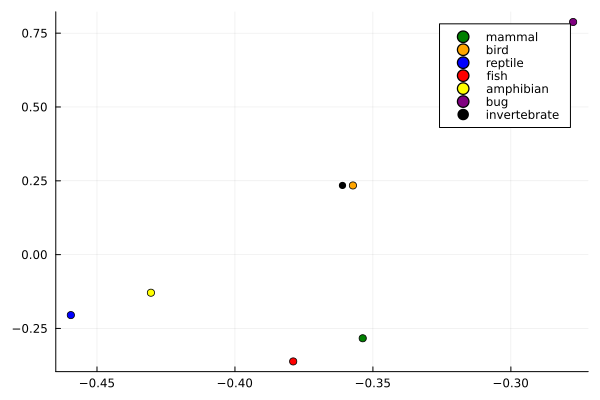

In [17]:
using Plots

function plotter()
    colors = [:green, :orange, :blue, :red, :yellow, :purple, :black]
    labels = ["mammal", "bird", "reptile", "fish", "amphibian", "bug", "invertebrate"]
    fig = Plots.plot()

    for i in 1:7
        scatter!(fig, (proj[i, 1], proj[i, 2]), label=labels[i], mc = colors[i])
    end
    return fig
end

plotter()

This doesn't seem to make much sense at first. Mammals are apparently very similar to fish and birds to invertebrate. On top of that, only roughly 60 % of the variance in the data is explained by the two first principle components. Although it makes sense that reptiles and amphibians are relatively similar from an evolutionary standpoint. It is very likely however that this plot would look much better after implementing a higher variety of features into the data.

Now we will do an PCA analysis considering every animal seperately.

In [18]:
matrix_species = permutedims(hcat(hdv...))

S = fit(PCA, matrix_species ; maxoutdim=2)
projS = projection(S)
S

PCA(indim = 101, outdim = 2, principalratio = 0.4986661864105027)

Pattern matrix (unstandardized loadings):
──────────────────────────
          PC1          PC2
──────────────────────────
1    0.334524  -0.188874
2    0.354106  -0.199807
3    0.272936   0.160797
4    0.3306    -0.184847
5    0.414769  -0.222574
6    0.354912  -0.197792
7    0.371457  -0.215149
8    0.239544   0.139385
9    0.273677   0.164692
10   0.302305  -0.189634
11   0.414769  -0.222574
12   0.262178   0.193087
13   0.270721   0.169005
14   0.156904   0.199037
15   0.164722   0.117277
16   0.133293   0.177757
17   0.287063   0.214003
18   0.352688  -0.203902
19   0.30671    0.144853
20   0.325502   0.00852006
21   0.260094   0.197483
22   0.267713   0.243263
23   0.35493   -0.200285
24   0.282575   0.179618
25   0.17205    0.164246
26   0.321594   0.0779563
27   0.278207   0.0716469
28   0.303654  -0.0458663
29   0.354337  -0.199486
30   0.325119  -0.117479
31   0.155821   0.169734
32   0.371457  -0.215149
33   

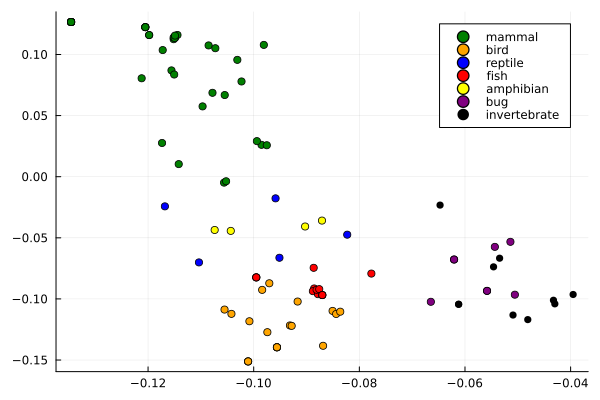

In [19]:
using Plots

function plotter()
    colors = [:green, :orange, :blue, :red, :yellow, :purple, :black]
    labels = ["mammal", "bird", "reptile", "fish", "amphibian", "bug", "invertebrate"]
    fig = Plots.plot()

    for i in 1:7
        scatter!(fig, projS[indices[i], 1], projS[indices[i], 2], mc = colors[i], label=labels[i])
    end
    return fig
end

plotter()


Even though only roughly half of the variance in the data is explained by the two first principle components, we have obtained a nicely clustered scatter plot considering the simplicity of our data set. It makes much sense on how the animals are seperated. With an higher variety of features, we could also improve the distinction between reptiles and amphibian and that of between bugs and invertebrate.